In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import networkx as nx
import time
import os
import csv

import math
import pickle


from gerrychain import Graph, Partition, Election
from gerrychain.updaters import Tally, cut_edges
from gerrychain import MarkovChain
from gerrychain.constraints import single_flip_contiguous
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.constraints.validity import within_percent_of_ideal_population
from gerrychain.metrics import mean_median,efficiency_gap
from gerrychain.proposals import recom
from functools import partial
from gerrychain.tree import recursive_tree_part


from matplotlib.pyplot import figure

#We are importing more than we need, this has all the infastructure to do MCMC analysis

In [3]:
#load shapefile into graph
graph = Graph.from_file("Desktop/BethSummerResearch/Data/CO_Shapefile_2018_Jan2020/co_precincts.shp")

In [4]:
#print Graph
graph

<Graph [3084 nodes, 8682 edges]>

In [5]:
#make a bunch of layouts to display the colorado graph in cool ways
spring = nx.spring_layout(graph)
spectralLayout = nx.spectral_layout(graph)
spiral = nx.spiral_layout(graph)
kamada_kawai = nx.kamada_kawai_layout(graph)


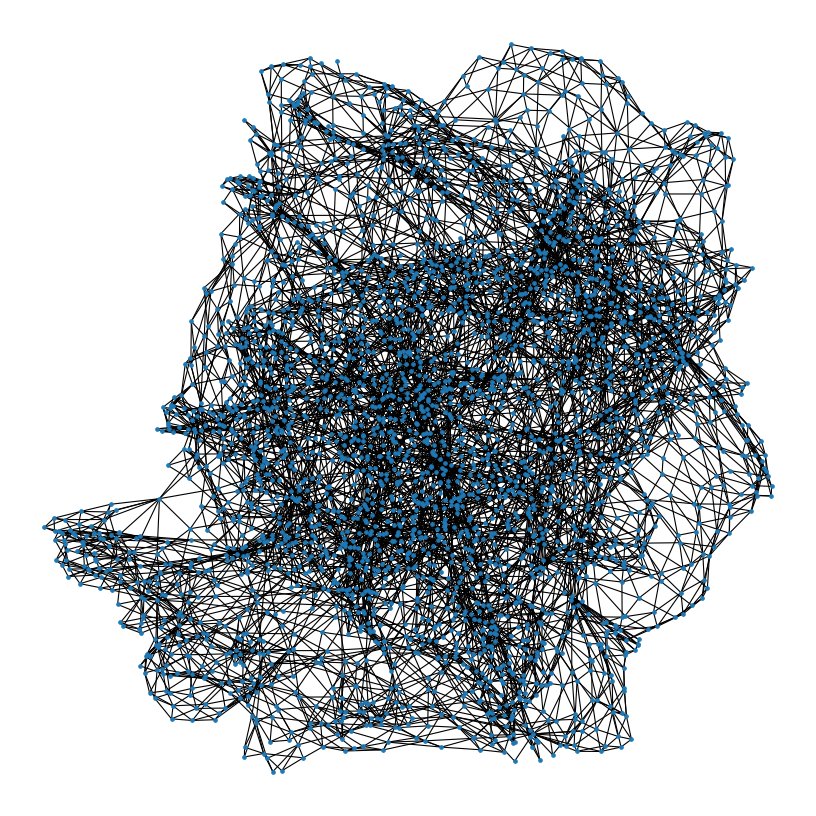

In [6]:
figure(figsize=(10, 10), dpi=80)
nx.draw(graph,pos = spring, node_size = 10)

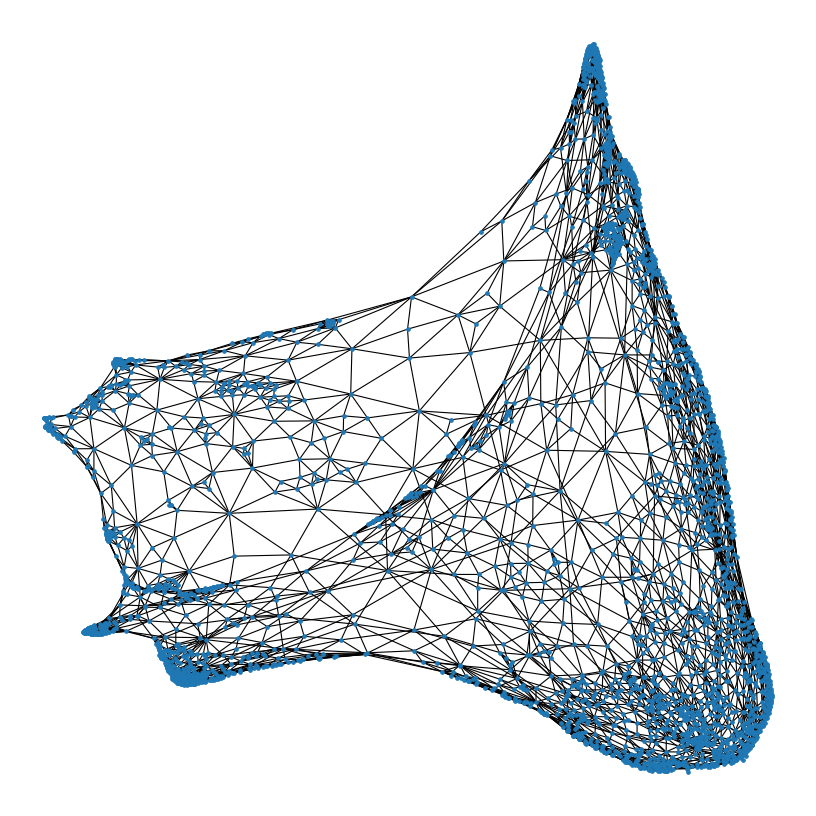

In [7]:
figure(figsize=(10, 10), dpi=80)
nx.draw(graph, pos = spectralLayout,node_size = 10)


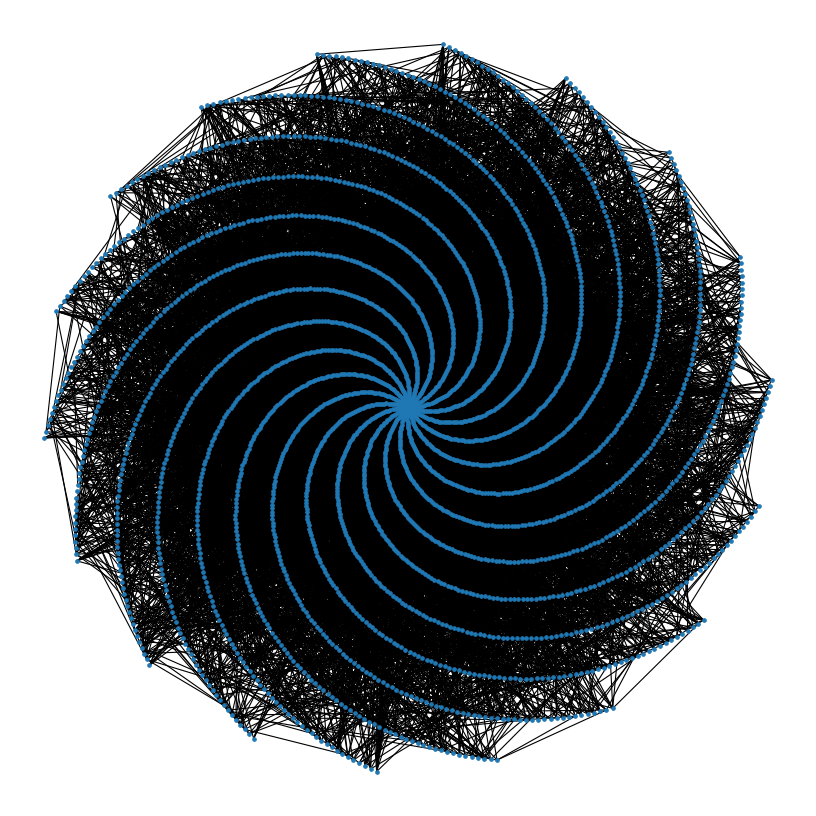

In [8]:
figure(figsize=(10, 10), dpi=80)
nx.draw(graph, pos = spiral,node_size = 10)


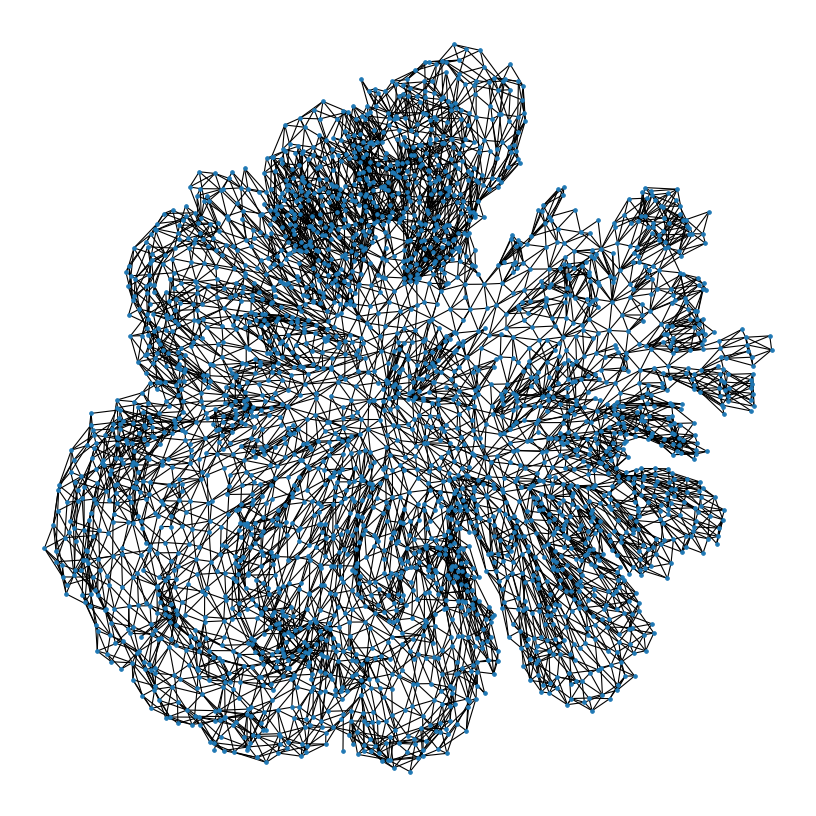

In [9]:
figure(figsize=(10, 10), dpi=80)
nx.draw(graph, pos = kamada_kawai,node_size = 10)

In [10]:
#read the shapefile in terms of attribue table
df = gpd.read_file("Desktop/BethSummerResearch/Data/CO_Shapefile_2018_Jan2020/co_precincts.shp")

In [11]:
for col in df.columns:
    print(col)

COUNTYFP
VTDST
NAME
CD116FP
SLDUST
SLDLST
PRECID
AG18D
AG18R
SOS18D
SOS18R
TRE18D
TRE18R
GOV18D
GOV18R
REG18D
REG18R
USH18D
USH18R
TOTPOP
NH_WHITE
NH_BLACK
NH_AMIN
NH_ASIAN
NH_NHPI
NH_OTHER
NH_2MORE
HISP
H_WHITE
H_BLACK
H_AMIN
H_ASIAN
H_NHPI
H_OTHER
H_2MORE
VAP
HVAP
WVAP
BVAP
AMINVAP
ASIANVAP
NHPIVAP
OTHERVAP
2MOREVAP
geometry


In [12]:
#set a bunch of global variables both for MCMC but also to parse over the map to generate data
global unique_label 
unique_label = "PRECID"  #Unique identifier for the voting district

global population_col
population_col = "TOTPOP" 


global district_col_CD
district_col_CD = "CD116FP" #Change for: state house (SLDLST) or house senate district (SLDUST) or congressional (CD116FP)
global district_col_SLD
district_col_SLD = "SLDLST" #Change for: state house (SLDLST) or house senate district (SLDUST) or congressional (CD116FP)
global district_col_SUD
district_col_SUD = "SLDUST" #Change for: state house (SLDLST) or house senate district (SLDUST) or congressional (CD116FP)


global county_col
county_col = "COUNTYFP"

In [13]:
#create list of races we are interested in

election_names = [
    "GOV", "AG", "SEC", "TRE", "REG"
]

election_columns = [
    ["GOV18D", "GOV18R"], ["AG18D","AG18R"], ["SOS18D","SOS18R"],["TRE18D","TRE18R"],["REG18D","REG18R"]
]

In [14]:
# Number of districts in Congressional, State Senate, State House
num_elections = len(election_names)
num_districts_CD = 7 
num_districts_SUD = 35
num_districts_SLD = 65

In [15]:
#elections crawler
elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(num_elections)
]

In [16]:
# updaters keep track of info throughout the markov chain as well as our initial generation of data

updaters = {"population": updaters.Tally(population_col, alias="population"),"cut_edges": cut_edges}

election_updaters = {election.name: election for election in elections}

updaters.update(election_updaters)

enacted_plan = GeographicPartition(graph, assignment=district_col_CD, updaters=updaters)

#print(enacted_plan["population"])
total_pop = sum(enacted_plan["population"].values())

ideal_pop_CD = int(total_pop/7)   # 7 Congressional seats
ideal_pop_SUD = int(total_pop/35)   # 35 State Senate seats   
ideal_pop_SLD = int(total_pop/65)   # 65 State House seats

print("Total population:", total_pop)
print("Ideal CD population:", ideal_pop_CD)
print("Ideal SUD population:", ideal_pop_SUD)
print("Ideal SLD population:", ideal_pop_SLD)

{'01': 718134, '06': 718139, '04': 718126, '07': 718260, '05': 718327, '03': 718239, '02': 718379}
Total population: 5027604
Ideal CD population: 718229
Ideal SUD population: 143645
Ideal SLD population: 77347


In [18]:
#get info about graph so we can see whats going on 
graph.nodes()[0]

{'boundary_node': False,
 'area': 20904.433802334177,
 'COUNTYFP': '005',
 'VTDST': '005230',
 'NAME': 'Arapahoe 230',
 'CD116FP': '01',
 'SLDUST': '031',
 'SLDLST': '009',
 'PRECID': 1310903230,
 'AG18D': 0,
 'AG18R': 0,
 'SOS18D': 0,
 'SOS18R': 0,
 'TRE18D': 0,
 'TRE18R': 0,
 'GOV18D': 0,
 'GOV18R': 0,
 'REG18D': 0,
 'REG18R': 0,
 'USH18D': 0,
 'USH18R': 0,
 'TOTPOP': 0,
 'NH_WHITE': 0,
 'NH_BLACK': 0,
 'NH_AMIN': 0,
 'NH_ASIAN': 0,
 'NH_NHPI': 0,
 'NH_OTHER': 0,
 'NH_2MORE': 0,
 'HISP': 0,
 'H_WHITE': 0,
 'H_BLACK': 0,
 'H_AMIN': 0,
 'H_ASIAN': 0,
 'H_NHPI': 0,
 'H_OTHER': 0,
 'H_2MORE': 0,
 'VAP': 0,
 'HVAP': 0,
 'WVAP': 0,
 'BVAP': 0,
 'AMINVAP': 0,
 'ASIANVAP': 0,
 'NHPIVAP': 0,
 'OTHERVAP': 0,
 '2MOREVAP': 0,
 'geometry': <shapely.geometry.polygon.Polygon at 0x17f0321c190>}

In [ ]:
#generating some random seeds so we can look at a race
seeds_CD = []

for i in range(3):
    seeds_CD.append(recursive_tree_part(graph, range(7), ideal_pop_CD, population_col, .005, 1))


seed_partitions_CD = []

for i in range(len(seeds_CD)):
    seed_partitions_CD.append(GeographicPartition(graph, assignment=seeds_CD[i], updaters=updaters))

seed_partitions_CD

cuts=[]
AGDV=[]
SECDV=[]
TREDV=[]
GOVDV=[]
REGDV=[]

i=0
for i in range(len(seed_partitions_CD)):
      
    cuts.append(len(cut_edges(seed_partitions_CD[i])))
    AGDV.append(sorted(list(seed_partitions_CD[i]['AG'].percents("Democratic"))))
    SECDV.append(sorted(list(seed_partitions_CD[i]['SEC'].percents("Democratic"))))
    TREDV.append(sorted(list(seed_partitions_CD[i]['TRE'].percents('Democratic'))))
    GOVDV.append(sorted(list(seed_partitions_CD[i]['GOV'].percents("Democratic"))))
    REGDV.append(sorted(list(seed_partitions_CD[i]['REG'].percents('Democratic'))))

df_cuts=pd.DataFrame(cuts)
df_AGDV=pd.DataFrame(AGDV)
df_SECDV=pd.DataFrame(SECDV)
df_TREDV=pd.DataFrame(TREDV)
df_GOVDV=pd.DataFrame(GOVDV)
df_REGDV=pd.DataFrame(REGDV)

fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

#Loops through the above dataframe and grabs the value in the jth row for each column
colorlist = ['red', 'blue', 'green']
plt.plot(df_AGDV.iloc[0], "o", color=colorlist[0])
plt.plot(df_AGDV.iloc[1], "o", color=colorlist[1])
plt.plot(df_AGDV.iloc[2], "o", color=colorlist[2])

plt.xlabel('Re-indexed Districts')
plt.ylabel('Democratic Voting Percentage')
plt.title('Dem Voting Percentage: Attorney General')

In [ ]:
graphForRun = nx.Graph()

In [ ]:
#add attributes in the format we need
for i in graph.nodes():
    #this should be the precinct pop divided by total pop for precinct pop percentage
    graph.nodes()[i]['popPercent'] = graph.nodes()[i]['TOTPOP'] / total_pop
    #for some reason there are precincts without people, so we have to do this check
    temp = 1
    if graph.nodes()[i]['TOTPOP'] != 0:
        temp = graph.nodes()[i]['TOTPOP']
    graph.nodes()[i]['minPercent'] = ((graph.nodes()[i]['NH_BLACK'] + graph.nodes()[i]['NH_AMIN'] + graph.nodes()[i]['NH_ASIAN'] + graph.nodes()[i]['NH_NHPI'] + graph.nodes()[i]['NH_OTHER'] + graph.nodes()[i]['NH_2MORE'] + graph.nodes()[i]['HISP'] ) / temp) * .16 *graph.nodes()[i]['popPercent'] 
    temp1 = 1
    #same issue as above, this one is for party data
    if graph.nodes()[i]['GOV18D'] + graph.nodes()[i]['GOV18R'] != 0:
        temp1 = graph.nodes()[i]['GOV18D'] + graph.nodes()[i]['GOV18R']
    graph.nodes()[i]['demPercent'] = graph.nodes()[i]['GOV18D']/( temp1) * .495 * graph.nodes()[i]['popPercent']
    
graph.nodes()[82]